In [ ]:
!pip3 uninstall keras-nightly
!pip3 uninstall -y tensorflow
!pip3 install keras==2.1.6
!pip3 install tensorflow==1.15.0
!pip3 install h5py==2.10.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/Building_Facade_Parsing_using_Mask_RCNN/Mask_RCNN")
!pwd


/content/drive/My Drive/Colab Notebooks/Building_Facade_Parsing_using_Mask_RCNN/Mask_RCNN


In [ ]:
%matplotlib inline
import sys
import random
import math
import re
import time
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
#print(tf.__version__)
import skimage.io

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
ROOT_DIR = os.path.abspath("../")
#print(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

IMAGE_DIR = os.path.join(ROOT_DIR, "Images/")

TensorFlow 1.x selected.


Using TensorFlow backend.


## Configurations

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Master Thesis By Mola")

import building_facade
config = building_facade.CustomConfig()
#Testset Directory
FACADE_DIR = ROOT_DIR+"/TestSet"


dataset = building_facade.CustomDataset()
#dataset = building_facade_aug_v1.CustomDataset()
dataset.load_custom(FACADE_DIR, "val")
#
# Must call before using the dataset
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 10
Classes: ['BG', 'window', 'wall', 'basement_window', 'door', 'balcony']


In [ ]:
# Override the training configurations with a few changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                18
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [ ]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.

# set target device
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

#def get_ax(rows=1, cols=1, size=16):
def get_ax(rows=1, cols=1, size=10):
    """
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

##Load Model

In [ ]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs/")
print(MODEL_DIR)
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

#test0
# Step 1 @ last epoch LR+
#weights_path = "../logs/custom20210511T1008/mask_rcnn_custom_0050.h5" # mAP @ IoU=50:  0.8286637968287558

# Step  @ lowest training los
#weights_path = "../logs/custom20210511T1008/mask_rcnn_custom_0049.h5" # mAP @ IoU=50:  0.8432020581495931

# Step 1 @ last epoch
#weights_path = "../logs/custom20210511T1008/mask_rcnn_custom_0047.h5" # 0.86006

# FlipLR
#weights_path = "../logs/custom20210522T1518_flirlr/mask_rcnn_custom_0002.h5" # 0.86006

#LR+001,step+epoch+180,valida+80 
#weights_path = "../logs/custom20210518T1650/mask_rcnn_custom_0040.h5" # 0.8412

# Affine and rotate
weights_path = "../logs/custom20210523T2004_affine/mask_rcnn_custom_0006.h5" # 0.88006
 
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

/content/drive/My Drive/Colab Notebooks/Master Thesis By Mola/logs/
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.
Loading weights  ../logs/custom20210523T2004_affine/mask_rcnn_custom_0006.h5


## For single Image Detection

Processing 1 images
image                    shape: (850, 619, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32



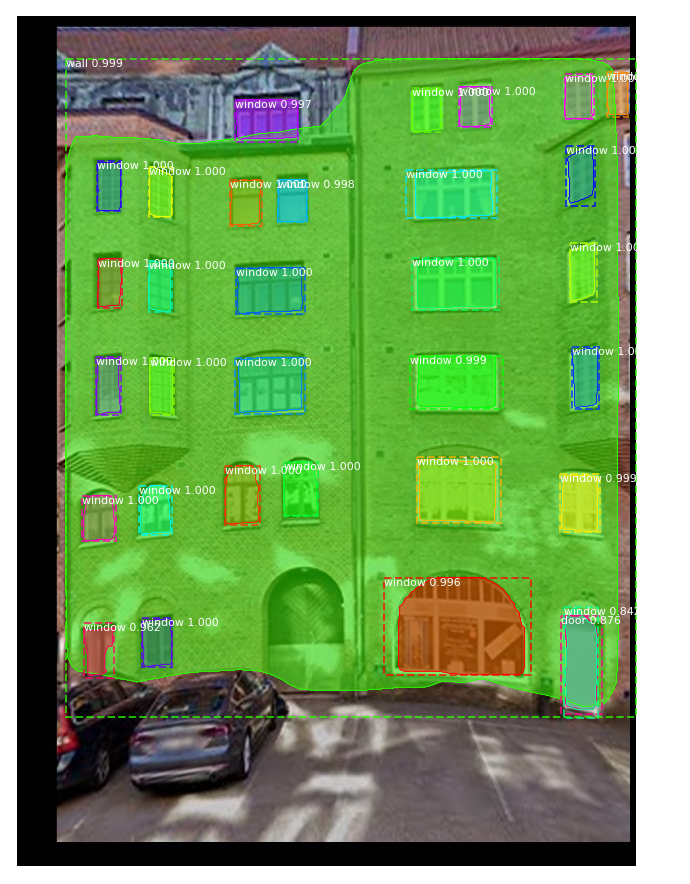

In [ ]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
# image = skimage.io.imread(os.path.join(IMAGE_DIR, '9247489789_132c0d534a_z.jpg'))
image = skimage.io.imread(os.path.join(IMAGE_DIR, 'Building_1.jpg'))
# Run detection
results = model.detect([image], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

Processing 1 images
image                    shape: (1000, 1000, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


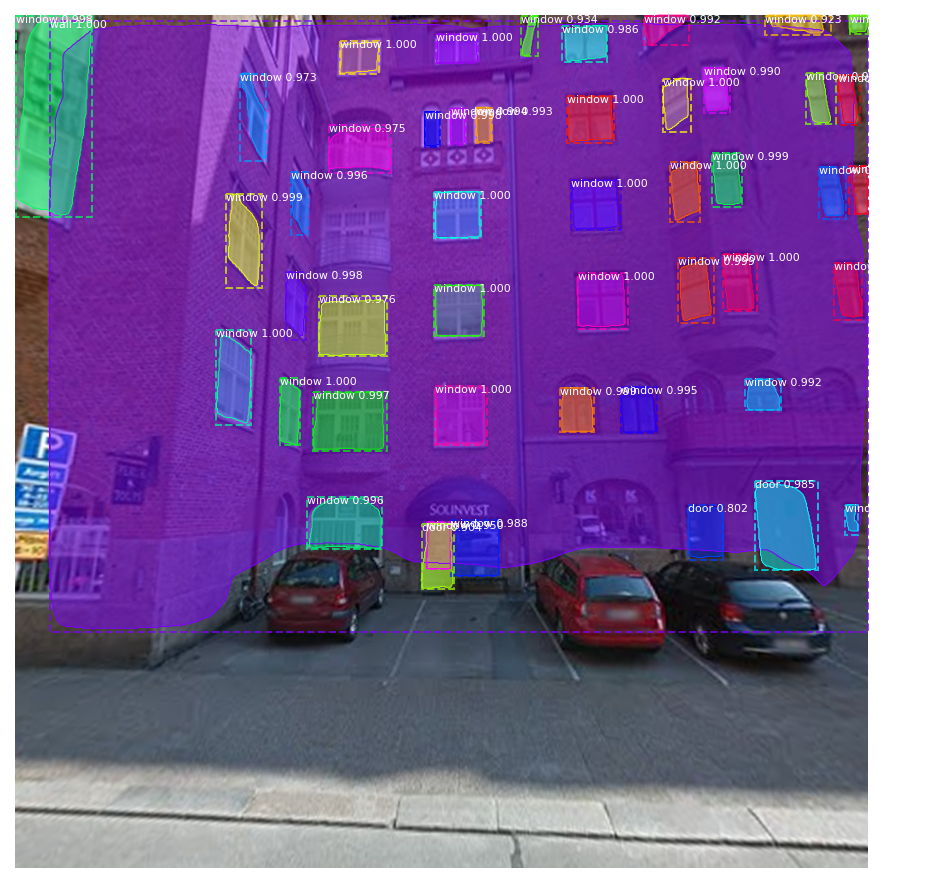

In [ ]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
# image = skimage.io.imread(os.path.join(IMAGE_DIR, '9247489789_132c0d534a_z.jpg'))
image = skimage.io.imread(os.path.join(IMAGE_DIR, 'Extracted_images_00.jpg'))

# Run detection
results = model.detect([image], verbose=1)
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], dataset.class_names, r['scores'])

## Run Detection

image ID: custom.munich_000005.jpg (7) /content/drive/My Drive/Colab Notebooks/Master Thesis By Mola/TestSet/val/munich_000005.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


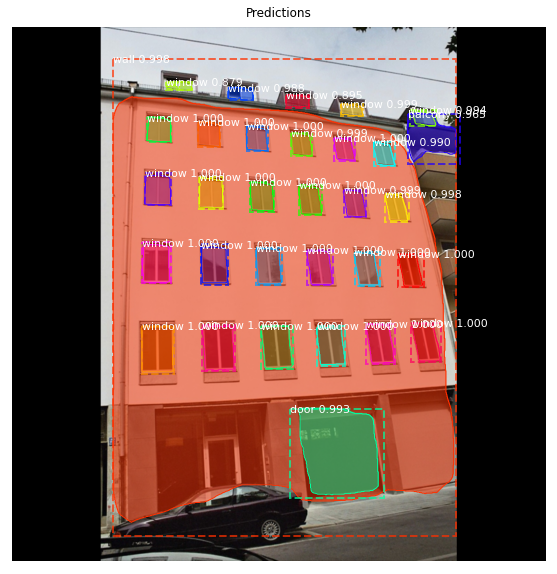

In [ ]:
image_id = random.choice(dataset.image_ids)
#image_id = 0 #correct
#image_id = 1 #ciorrect
#image_id = 2
#image_id = 3  #correct
#image_id = 4
#image_id = 5
#image_id = 6
image_id = 7
#image_id = 8
#image_id = 9
#image_id = 10

image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)
#window.astype(np.int32)
# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

image_id  7 /content/drive/My Drive/Colab Notebooks/Master Thesis By Mola/TestSet/val/munich_000005.jpg
image                    shape: (768, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (768, 512, 42)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (42,)                 min:    1.00000  max:    5.00000  int32
bbox                     shape: (42, 4)               min:    0.00000  max:  727.00000  int32


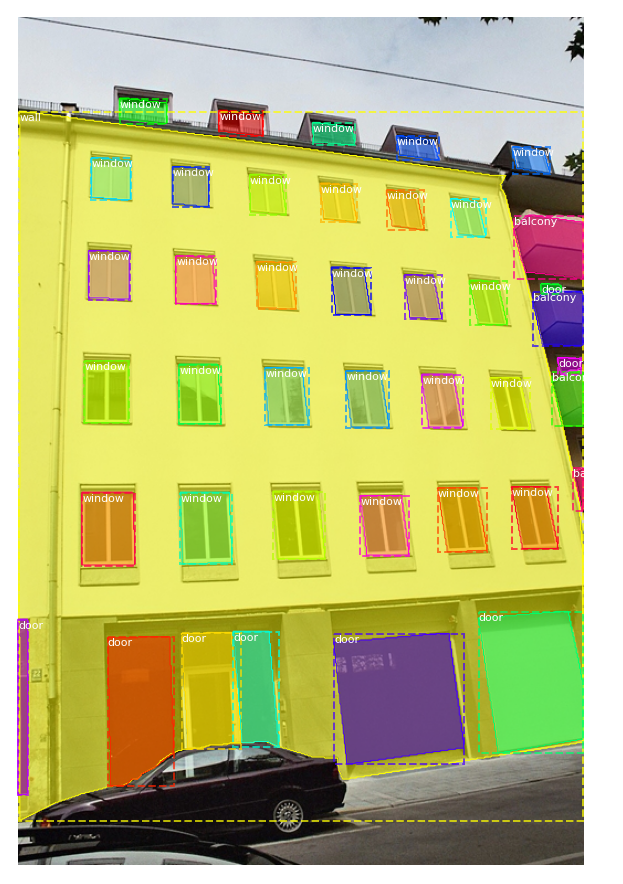

7


In [ ]:
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

print(image_id)

### Load Ground Truth Image After Augmentation

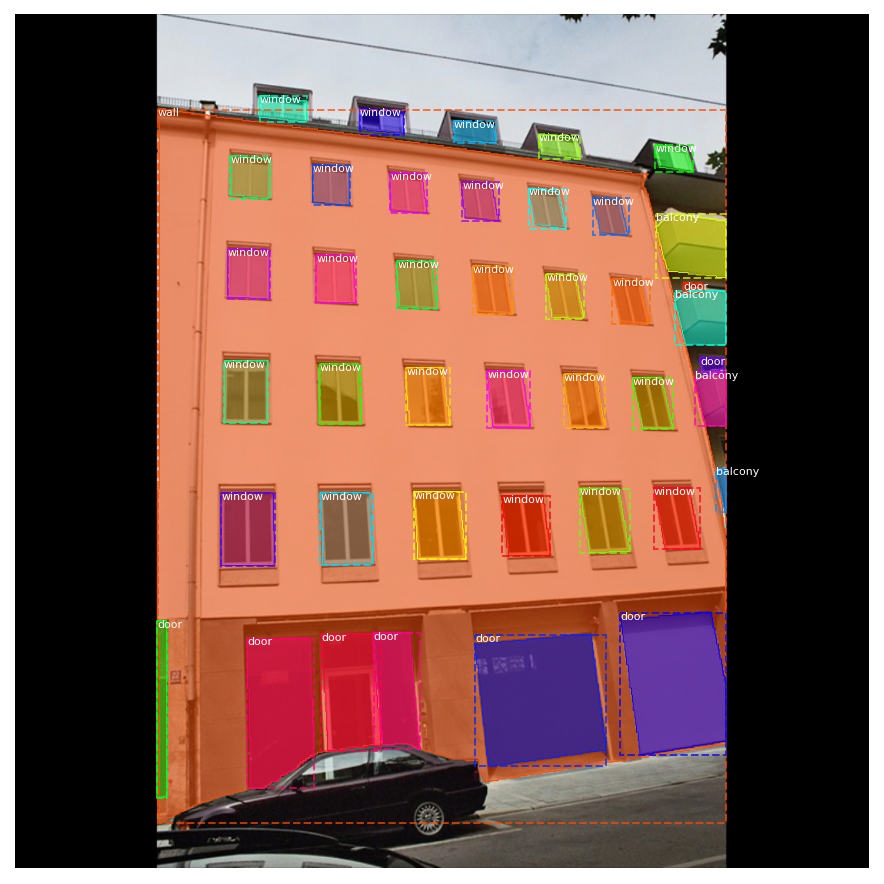

7


In [ ]:


image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(dataset, config, image_id, augment=False, 
                  use_mini_mask=False)

visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

print(image_id)

##crop and resize feature map

### Precision-Recall

Precision measures how accurate is your predictions. i.e. the percentage of your predictions are correct
Recall measures how good you find all the positives. For example, we can find 80% of the possible positive cases in our top K predictions.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.96774194 0.96774194 0.9375     0.        ]
[0.         0.02380952 0.04761905 0.07142857 0.0952381  0.11904762
 0.14285715 0.16666667 0.19047619 0.21428572 0.23809524 0.26190478
 0.2857143  0.30952382 0.33333334 0.35714287 0.38095239 0.40476191
 0.42857143 0.45238096 0.47619048 0.5        0.52380955 0.54761904
 0.5714286  0.59523809 0.61904764 0.64285713 0.66666669 0.69047618
 0.69047618 0.71428573 0.71428573 1.        ]


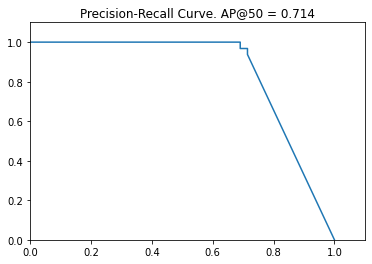

In [ ]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
#print(AP)88888889
print(precisions)
print(recalls)
#print(overlaps)
visualize.plot_precision_recall(AP, precisions, recalls)

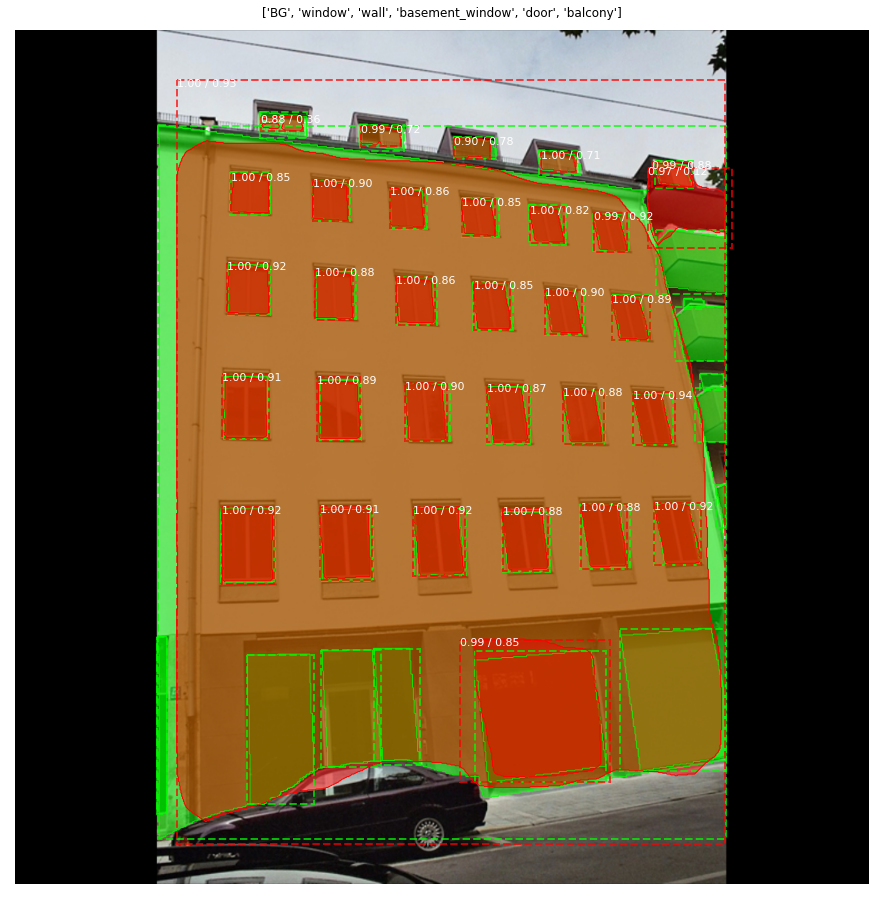

In [ ]:
visualize.display_differences(image, gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'],r['class_ids'], dataset.class_names)

In [ ]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],overlaps, dataset.class_names)

### Evaluation for all classes

In [ ]:
# Compute VOC-style Average Precision
# utils_all_classes_accurcay.py
def compute_batch_ap(image_ids):
    APs = []

    for image_id in image_ids:                
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
        #print(APs)

        print(image_id, AP)

    return APs

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 2)

# Pick all of the images in validation set!
image_ids = dataset.image_ids
print(image_ids)
APs = compute_batch_ap(image_ids)
print(APs)
print("mAP @ IoU=50: ", np.mean(APs))

[0 1 2 3 4 5 6 7 8 9]
0 0.8678886758141862
1 0.8541666753590107
2 0.7997685185185184
3 0.9032257795333862
4 0.8936635707105909
5 1.0
6 0.93359375
7 0.7135176812448809
8 0.8965517282485962
9 0.8163265415600367
[0.8678886758141862, 0.8541666753590107, 0.7997685185185184, 0.9032257795333862, 0.8936635707105909, 1.0, 0.93359375, 0.7135176812448809, 0.8965517282485962, 0.8163265415600367]
mAP @ IoU=50:  0.8678702920989206


##Evaluate for each class
 ### To compute class-wise accuracy, change 

In [ ]:
# Compute VOC-style Average Precision
# utils_class_wise_accurcay.py
def compute_batch_ap(image_ids):
    APs_window = []
    APs_wall = []
    APs_basement = []
    APs_door = []
    APs_balcony = []
    for image_id in image_ids:                
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP_window, AP_wall, AP_basement, AP_door, AP_balcony =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs_window.append(AP_window)
        APs_wall.append(AP_wall)
        APs_basement.append(AP_basement)
        APs_door.append(AP_door)
        APs_balcony.append(AP_balcony)

             

    return APs_window, APs_wall, APs_basement, APs_door, APs_balcony

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 2)
print("---------------------------")
# Pick all of the images in validation set!
image_ids = dataset.image_ids
#print(image_ids)
APs_window, APs_wall, APs_basement, APs_door, APs_balcony = compute_batch_ap(image_ids)
#print("window:", APs_window)
#print("wall:", APs_wall)
#print("basement:", APs_basement)
#print("door:", APs_door)
#print("balcony:", APs_balcony)
l_window = np.array(APs_window)
l_wall = np.array(APs_wall)
l_basement = np.array(APs_basement)
l_door = np.array(APs_door)
l_balcony = np.array(APs_balcony)

print("------------------------------")
#print("window mAP @ IoU=50: ", np.mean(APs_window))
#print("wall mAP @ IoU=50: ", np.mean(APs_wall))
#print("basement mAP @ IoU=50: ", np.mean(APs_basement))
#print("door mAP @ IoU=50: ", np.mean(APs_door))
#print("balcony mAP @ IoU=50: ", np.mean(APs_balcony))

print("window mAP @ IoU=50: ", l_window[np.nonzero(l_window)].mean())
#print("window mAP @ IoU=50: ", l_window[l_window>0.8].mean())

print("wall mAP @ IoU=50: ", l_wall[np.nonzero(l_wall)].mean())
#print("wall mAP @ IoU=50: ", l_wall[l_wall>0.8].mean())


print("basement mAP @ IoU=50: ", l_basement[np.nonzero(l_basement)].mean())
#print("basement mAP @ IoU=50: ", l_basement[l_basement>0.8].mean())


print("door mAP @ IoU=50: ", l_door[np.nonzero(l_door)].mean())
#print("door mAP @ IoU=50: ", l_door[l_door >0.8].mean())


print("balcony mAP @ IoU=50: ", l_balcony[np.nonzero(l_balcony)].mean())
#print("balcony mAP @ IoU=50: ", l_balcony[l_balcony>0.8].mean())

---------------------------
------------------------------
window mAP @ IoU=50:  0.8600854005966904
wall mAP @ IoU=50:  0.3839032888412476
basement mAP @ IoU=50:  0.8035853055364828
door mAP @ IoU=50:  0.7493917219051651
balcony mAP @ IoU=50:  0.5207270468984331


In [ ]:
# For single image

In [ ]:
# Compute VOC-style Average Precision
# utils_class_wise_accurcay.py
def compute_batch_ap(image_ids):
    APs_window = []
    APs_wall = []
    APs_basement = []
    APs_door = []
    APs_balcony = []
    # Load image
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config,
                              image_id, use_mini_mask=False)
    # Run object detection
    results = model.detect([image], verbose=0)
    # Compute AP
    r = results[0]
    AP_window, AP_wall, AP_basement, AP_door, AP_balcony =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                          r['rois'], r['class_ids'], r['scores'], r['masks'])
    APs_window.append(AP_window)
    APs_wall.append(AP_wall)
    APs_basement.append(AP_basement)
    APs_door.append(AP_door)
    APs_balcony.append(AP_balcony)

    #print(image_id, AP_window)
    #print(image_id, AP_wall)
    #print(image_id, AP_basement)
    #print(image_id, AP_door)
    #print(image_id, AP_balcony)
    #print("#########################")                     

    return APs_window, APs_wall, APs_basement, APs_door, APs_balcony

# Pick a set of random images
#image_ids = np.random.choice(dataset.image_ids, 2)
print("---------------------------")
# Pick all of the images in validation set!
image_ids = dataset.image_ids
#print(image_ids)
APs_window, APs_wall, APs_basement, APs_door, APs_balcony = compute_batch_ap(image_ids)
#print("window:", APs_window)
#print("wall:", APs_wall)
#print("basement:", APs_basement)
#print("door:", APs_door)
#print("balcony:", APs_balcony)
l_window = np.array(APs_window)
l_wall = np.array(APs_wall)
l_basement = np.array(APs_basement)
l_door = np.array(APs_door)
l_balcony = np.array(APs_balcony)

print("------------------------------")
#print("window mAP @ IoU=50: ", np.mean(APs_window))
#print("wall mAP @ IoU=50: ", np.mean(APs_wall))
#print("basement mAP @ IoU=50: ", np.mean(APs_basement))
#print("door mAP @ IoU=50: ", np.mean(APs_door))
#print("balcony mAP @ IoU=50: ", np.mean(APs_balcony))

print("window mAP @ IoU=50: ", l_window[np.nonzero(l_window)].mean())
#print("window mAP @ IoU=50: ", l_window[l_window>0.8].mean())

print("wall mAP @ IoU=50: ", l_wall[np.nonzero(l_wall)].mean())
#print("wall mAP @ IoU=50: ", l_wall[l_wall>0.8].mean())


print("basement mAP @ IoU=50: ", l_basement[np.nonzero(l_basement)].mean())
#print("basement mAP @ IoU=50: ", l_basement[l_basement>0.8].mean())


print("door mAP @ IoU=50: ", l_door[np.nonzero(l_door)].mean())
#print("door mAP @ IoU=50: ", l_door[l_door >0.8].mean())


print("balcony mAP @ IoU=50: ", l_balcony[np.nonzero(l_balcony)].mean())
#print("balcony mAP @ IoU=50: ", l_balcony[l_balcony>0.8].mean())

---------------------------
------------------------------
window mAP @ IoU=50:  0.8108225081648146
wall mAP @ IoU=50:  0.03030303120613098
basement mAP @ IoU=50:  0.7319422641704822
door mAP @ IoU=50:  0.790811336809589
balcony mAP @ IoU=50:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:

display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    5.00000  float32
masks                    shape: (1, 100, 28, 28, 6)   min:    0.00000  max:    1.00000  float32
31 detections: ['window' 'window' 'window' 'window' 'wall' 'window' 'window' 'window'
 'window' 'window' 'window' 'window' 'window' 'window' 'window' 'window'
 'window' 'window' 'window' 'window' 'window' 'window' 'window' 'window'
 'window' 'window' 'door' 'window' 'balcony' 'window' 'window']


In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (31, 28, 28)          min:    0.00000  max:    1.00000  float32
det_masks                shape: (31, 1024, 1024)      min:    0.00000  max:    1.00000  bool


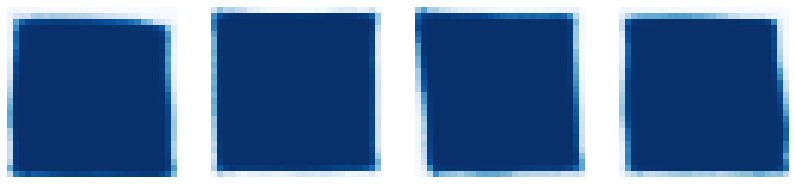

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

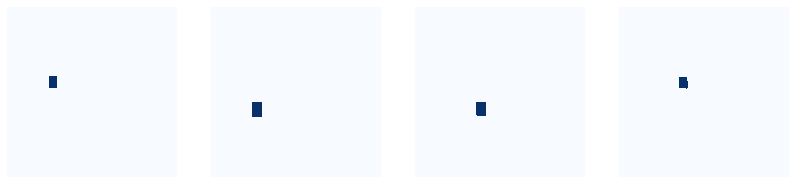

In [ ]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

In [ ]:
# Get activations of a few sample layersAugmentation is supposed to help prevent overfitting so one would expect validation loss to decrease better than when running the model without augmentation.
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  148.10001  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   61.64220  float32
rpn_bbox                 shape: (1, 261888, 4)        min:  -10.38089  max:   49.44471  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


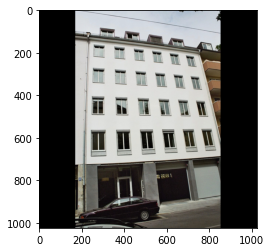

In [ ]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

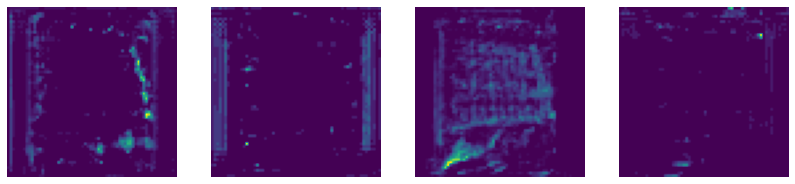

In [ ]:
# Backbone feature map
display_images(np.transpose(activations["res4w_out"][0,:,:,:4], [2, 0, 1]))

#1: Region Proposal Network

##1.a RPN Targets

In [ ]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -6.63701  max:    6.29767  float64
positive_anchors         shape: (128, 4)              min:  100.68629  max:  960.00000  float64
negative_anchors         shape: (128, 4)              min: -298.03867  max: 1061.25483  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (128, 4)              min:   97.00000  max:  969.00000  float32


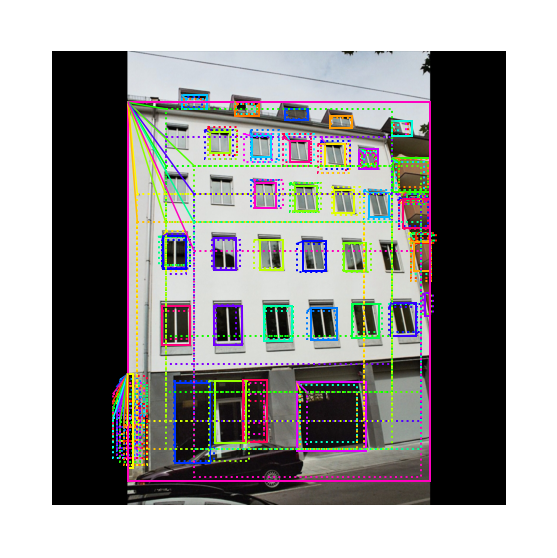

In [ ]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

##1.b RPN Predictions

In [ ]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.04109  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:   -0.17530  max:    1.46971  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (747,)                min:    0.00000  max: 5994.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


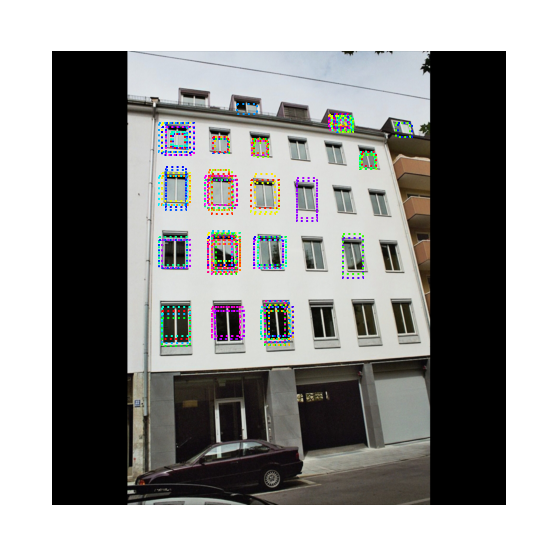

In [ ]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

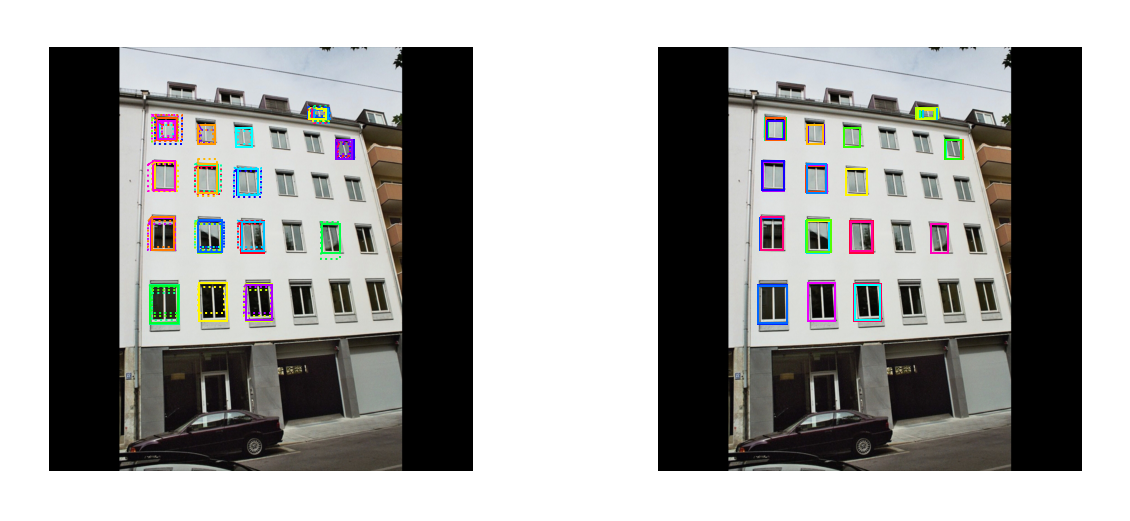

In [ ]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

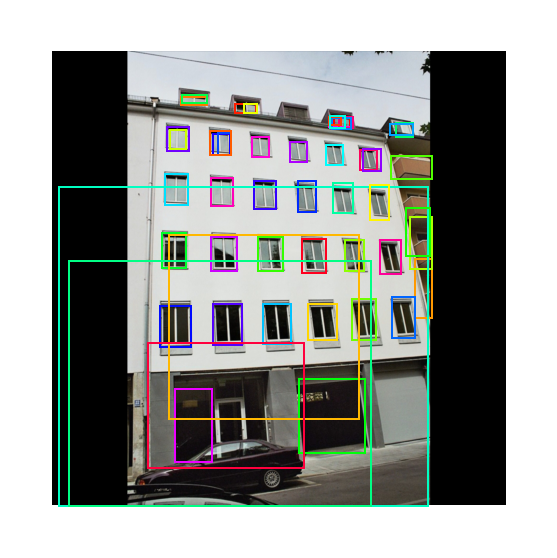

In [ ]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

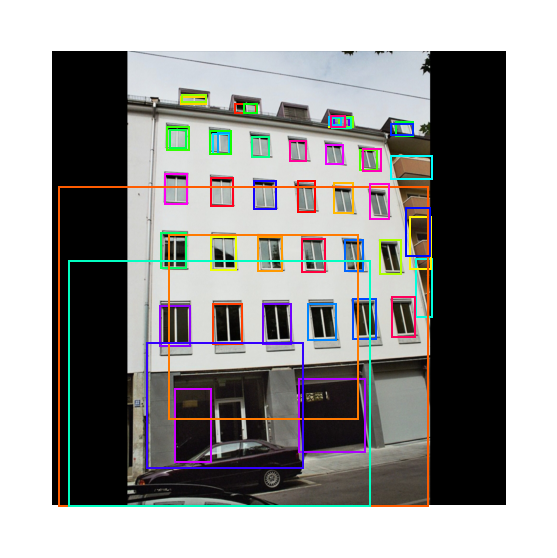

In [ ]:
# Show final proposals3.b Predicted Masks
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [ ]:
# Measure the RPN recall (percent of objects covered by anchors)
# Here we measure recall for 3 different methods:
# - All anchors
# - All refined anchors
# - Refined anchors after NMS
iou_threshold = 0.7

recall, positive_anchor_ids = utils.compute_recall(model.anchors, gt_bbox, iou_threshold)
print("All Anchors ({:5})       Recall: {:.3f}  Positive anchors: {}".format(
    model.anchors.shape[0], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(rpn['refined_anchors'][0], gt_bbox, iou_threshold)
print("Refined Anchors ({:5})   Recall: {:.3f}  Positive anchors: {}".format(
    rpn['refined_anchors'].shape[1], recall, len(positive_anchor_ids)))

recall, positive_anchor_ids = utils.compute_recall(proposals, gt_bbox, iou_threshold)
print("Post NMS Anchors ({:5})  Recall: {:.3f}  Positive anchors: {}".format(
    proposals.shape[0], recall, len(positive_anchor_ids)))

All Anchors (261888)       Recall: 0.405  Positive anchors: 58
Refined Anchors ( 6000)   Recall: 0.000  Positive anchors: 0
Post NMS Anchors (   50)  Recall: 0.571  Positive anchors: 25


#Stage 2: Proposal Classificatio

##2.a Proposal Classification

In [ ]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.10456  max:    1.00000  float32
probs                    shape: (1, 1000, 2)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 2, 4)       min:   -4.51145  max:    4.34182  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32


31 detections: ['window' 'window' 'window' 'window' 'wall' 'window' 'window' 'window'
 'window' 'window' 'window' 'window' 'window' 'window' 'window' 'window'
 'window' 'window' 'window' 'window' 'window' 'window' 'window' 'window'
 'window' 'window' 'door' 'window' 'balcony' 'window' 'window']


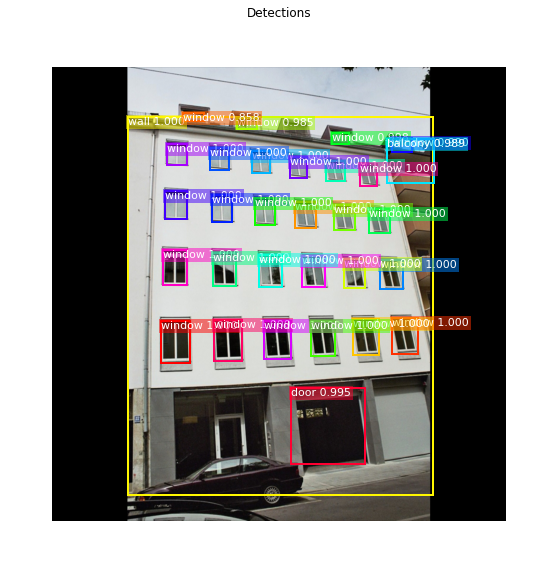

In [ ]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

##2.c Step by Step Detection

In [ ]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

KeyError: ignored

In [ ]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

NameError: ignored

##Apply Bounding Box Refinement

In [ ]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

KeyError: ignored

#Stage 3: Generating Masks

##3.a Mask Targets

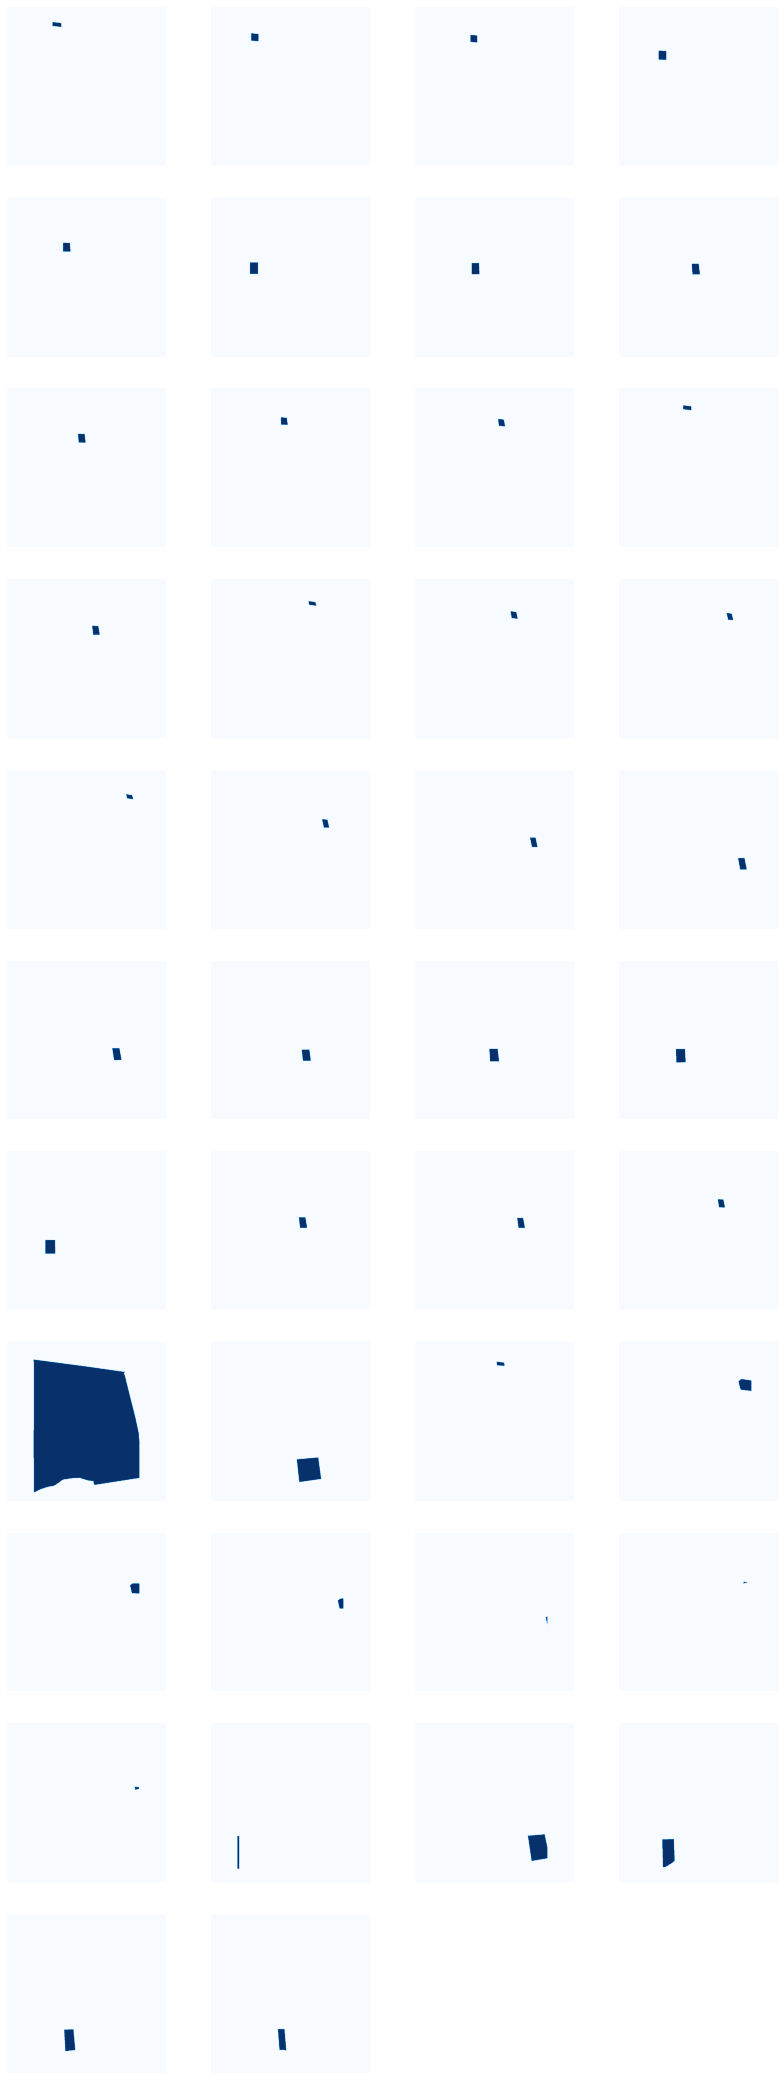

In [ ]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

##3.b Predicted Masks

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    1.00000  float32
masks                    shape: (1, 100, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
5 detections: ['window' 'window' 'window' 'window' 'window']


In [ ]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (5, 28, 28)           min:    0.00000  max:    1.00000  float32
det_masks                shape: (5, 1024, 1024)       min:    0.00000  max:    1.00000  bool


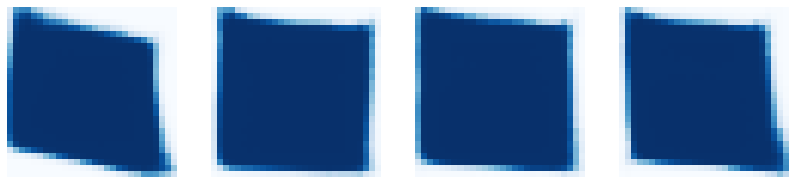

In [ ]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

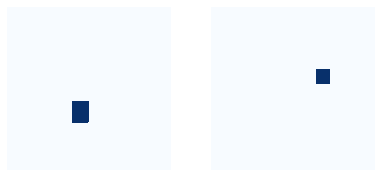

In [ ]:
display_images(det_masks[:2] * 255, cmap="Blues", interpolation="none")